# Evaluating the heat treatment of milk using front-face fluorescence spectroscopy: the chemometric model and a new spectral index

## Abstract.

A readily available, fast, non-destructive front-face fluorescence technique is used as a tool for assessing heat treatment effects on milk. Spectral data on raw, pasteurized, UHT pasteurized and sterilized milk samples from a wide range of manufacturers are obtained, including reconstituted milk and its mixtures with pasteurized milk. The principal component analysis (PCA) is used to summarize all the data obtained, and a classification model is developed to distinguish between two classes of milk (1) raw and pasteurized milk and (2) milk that was exposed to high heat treatment (UHT pasteurization or sterilization), or contains products of such a treatment (dry milk). A validation procedure using a test set showed the model to be accurate to within less than 5%. A new spectral index for use in the present context, which uses the ratio of the vitamin A and Maillard reaction products peaks in fluorescence excitation spectra, is proposed and compared with the conventional FAST index.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


%matplotlib inline

# Rewise the raw data

In [13]:
raw_data = pd.read_excel('Milk data.xlsx', sheetname='tr')

Form a target column

In [14]:
raw_data['target'] = (raw_data['class (o)'] == 'positive') * 1

Form a list of predictors

In [15]:
raw_predictors = list(raw_data.columns.values)[3:-1]

Scale the raw_data

In [16]:
scaler = StandardScaler()
scaler.fit(raw_data[raw_predictors])

data_scaled = pd.DataFrame(data=scaler.transform(raw_data[raw_predictors]), columns=raw_predictors)

data_scaled

,305,305.5,306,306.5,307,307.5,308,308.5,309,309.5,...,415.5.2,416.2,416.5.2,417.2,417.5.2,418.2,418.5.2,419.2,419.5.2,420.2
0,-0.474017,-0.415863,-0.412935,-0.358887,-0.339610,-0.355248,-0.312576,-0.305250,-0.257447,-0.253636,...,-0.577634,-0.563893,-0.615945,-0.461509,-0.536663,-0.460749,-0.500200,-0.427416,-0.546933,-0.563594
1,-0.558056,-0.540645,-0.543687,-0.541228,-0.518168,-0.513236,-0.546473,-0.501056,-0.512055,-0.571693,...,-0.364209,-0.337670,-0.450536,-0.487156,-0.409398,-0.354092,-0.390583,-0.374890,-0.529499,-0.405313
2,-1.051453,-1.031676,-0.999283,-1.010317,-1.060313,-1.068652,-1.087929,-1.117509,-1.096474,-1.134443,...,-0.636518,-0.848966,-0.810663,-0.836182,-0.770527,-0.890997,-0.885194,-0.924982,-0.867672,-0.935317
3,0.228021,0.227533,0.166852,0.259466,0.237905,0.233964,0.237783,0.242955,0.222737,0.251285,...,-1.111650,-1.134727,-1.101360,-1.163794,-1.142655,-1.245595,-1.016152,-1.104268,-1.116287,-1.061547
4,0.752163,0.726098,0.742850,0.820280,0.742976,0.768011,0.747360,0.762085,0.703232,0.697671,...,-1.091458,-1.052819,-1.033491,-1.062776,-1.128877,-0.955425,-0.969710,-0.983265,-1.056342,-0.948904
5,0.234861,0.333074,0.236696,0.310401,0.329957,0.282917,0.279205,0.267051,0.266974,0.288562,...,-1.271945,-1.195068,-1.286108,-1.247391,-1.275117,-1.246319,-1.329967,-1.268445,-1.147214,-1.197184
6,0.413435,0.390733,0.423266,0.475676,0.516932,0.450784,0.372996,0.381138,0.377706,0.366074,...,-1.112327,-1.197363,-1.138478,-1.146736,-1.196558,-1.181167,-1.202525,-1.213279,-1.049536,-1.118682
7,0.811485,0.833383,0.782268,0.798088,0.774357,0.755047,0.740343,0.676512,0.708070,0.677086,...,-0.970306,-1.048115,-1.054993,-0.987164,-1.028684,-1.046518,-1.135106,-0.998615,-1.046550,-1.024387
8,0.643339,0.589486,0.563010,0.549754,0.535080,0.590264,0.577341,0.595278,0.589528,0.568698,...,-0.435727,-0.469251,-0.413778,-0.451589,-0.483364,-0.455923,-0.408651,-0.410267,-0.414744,-0.442241
9,0.627900,0.608602,0.558486,0.617385,0.644015,0.595852,0.573090,0.571930,0.620978,0.609545,...,-1.144815,-1.069797,-1.106045,-1.055517,-1.165739,-1.065823,-1.070718,-1.088798,-1.210980,-1.052373


Select K best features for classification

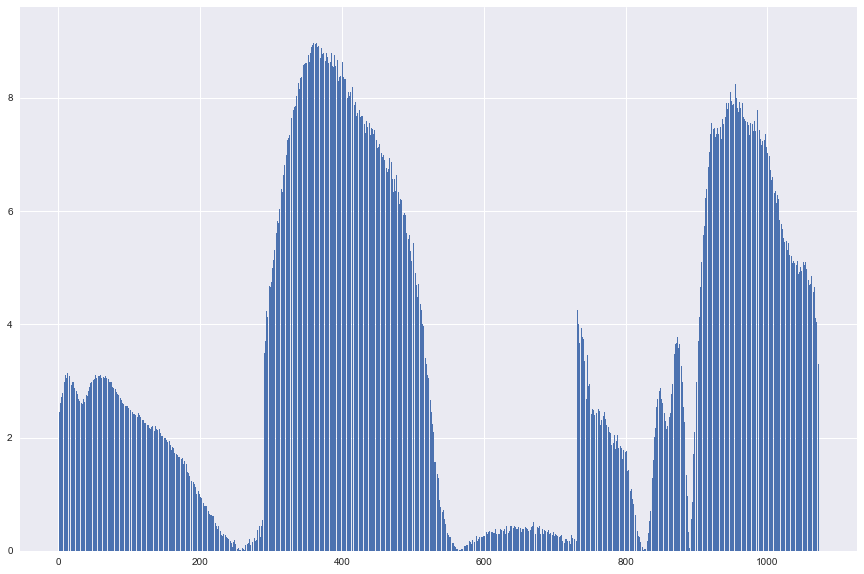

In [17]:
selector = SelectKBest(f_classif, k=5)
selector.fit(data_scaled[raw_predictors], raw_data["target"])

scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(15, 10))
plt.bar(range(len(raw_predictors)), scores)
# plt.xticks(range(len(raw_predictors)), raw_predictors, rotation='vertical')
plt.show()

## Apply decomposition techniques to the data

PCA - principal component analysis (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

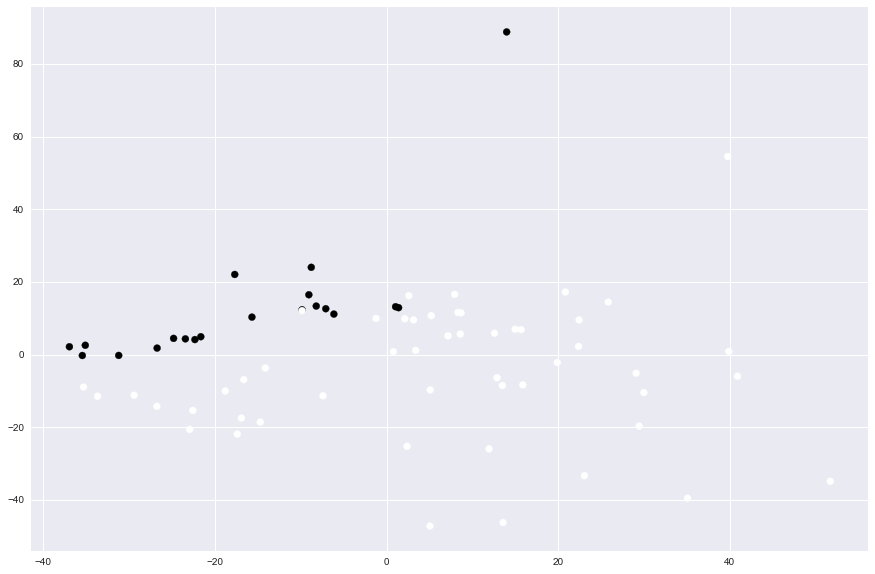

In [18]:
pca = PCA(n_components=10)
X = pca.fit_transform(data_scaled[raw_predictors], raw_data['target'])

plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1], c = raw_data['target'])

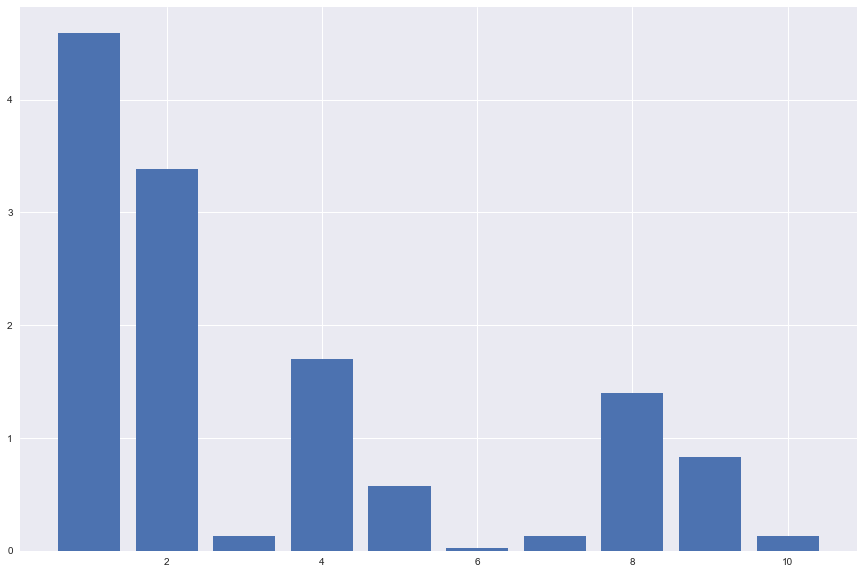

In [19]:
selector = SelectKBest(f_classif, k=5)
selector.fit(X, raw_data["target"])

scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(15, 10))
plt.bar(range(1, 10 + 1), scores)
# plt.xticks(range(len(raw_predictors)), raw_predictors, rotation='vertical')
plt.show()